In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import airportsdata

from sqlalchemy import create_engine

In [2]:
from db_config import db_config, conn_string
engine = create_engine(conn_string)

In [3]:
def read_table(table_name):
    return pd.read_sql(f"SELECT * FROM {table_name}", con=engine)

weather_df = read_table('weather')
planes_df = read_table('planes')
flights_df = read_table('flights')
airports_df = read_table('airports')
airlines_df = read_table('airlines')

In [4]:
# 1.1 - Paises con mas aterrizajes

# Cargamos la información de los aeropuertos utilizando la clave "LID"
airports_info = airportsdata.load("LID")

# Contamos los vuelos para cada destino
flight_counts = flights_df['dest'].value_counts().reset_index()
flight_counts.columns = ['dest', 'cantidad_vuelos']

# Calculamos el total de vuelos para posteriormente calcular porcentajes
total_flights = flight_counts['cantidad_vuelos'].sum()

# Mapeamos los nombres y países de los aeropuertos usando la información cargada
flight_counts['nombre_aeropuerto'] = flight_counts['dest'].map(
    lambda x: airports_info[x]['name'] if x in airports_info else 'Nombre desconocido'
)
flight_counts['pais'] = flight_counts['dest'].map(
    lambda x: airports_info[x]['country'] if x in airports_info else 'País desconocido'
)

# Sumamos todos los vuelos por país
totales_por_pais = flight_counts.groupby('pais')['cantidad_vuelos'].sum().reset_index()

# Calculamos el porcentaje del total de vuelos para cada país
totales_por_pais['porcentaje_del_total'] = (totales_por_pais['cantidad_vuelos'] / total_flights) * 100

# Ordenamos el DataFrame por el porcentaje de vuelos en orden descendente
totales_por_pais = totales_por_pais.sort_values(by='porcentaje_del_total', ascending=False)

# Seleccionamos los top 5 países con el mayor porcentaje de vuelos
top_5_paises = totales_por_pais.head(5)

# Imprimimos el resultado
print(top_5_paises)

  pais  cantidad_vuelos  porcentaje_del_total
0   US           336776                 100.0


In [5]:
# 1.2 - Aviones con más vuelos

# 1. Contamos el número total de vuelos en el conjunto de datos
total_flights = len(flights_df)

# 2. Contamos los vuelos para cada 'tailnum' único
conteo_vuelos_por_avion = flights_df['tailnum'].value_counts().reset_index()
conteo_vuelos_por_avion.columns = ['tailnum', 'cantidad_vuelos']

# 3. Calculamos el porcentaje del total de vuelos para cada 'tailnum'
conteo_vuelos_por_avion['porcentaje_del_total'] = (conteo_vuelos_por_avion['cantidad_vuelos'] / total_flights) * 100

# 4. Ordenamos el DataFrame por 'porcentaje_del_total' en orden descendente
conteo_vuelos_por_avion = conteo_vuelos_por_avion.sort_values(by='porcentaje_del_total', ascending=False)

# 5. Seleccionamos los top 5 aviones con el mayor porcentaje de vuelos
top_5_aviones = conteo_vuelos_por_avion.head(5)

# 6. Combinamos con planes_df para obtener información del fabricante y modelo
informacion_top_5_aviones = pd.merge(top_5_aviones, planes_df[['tailnum', 'manufacturer', 'model']], on='tailnum', how='left')

# 7. Imprimimos el resultado
print(informacion_top_5_aviones)

  tailnum  cantidad_vuelos  porcentaje_del_total          manufacturer   model
0  N725MQ              575              0.170737                   NaN     NaN
1  N722MQ              513              0.152327                   NaN     NaN
2  N723MQ              507              0.150545                   NaN     NaN
3  N711MQ              486              0.144310  GULFSTREAM AEROSPACE  G1159B
4  N713MQ              483              0.143419                   NaN     NaN


In [6]:
# 2. Aeropuerto con temperatura mas alta

# 1. Combinar weather_df y airports_df basado en la columna 'origin' en weather_df y la columna 'airport_code' en airports_df
merged_df = pd.merge(weather_df, airports_df, left_on='origin', right_on='airport_code', how='inner')

# 2. Encontrar la fila con la temperatura máxima
max_temp_row = merged_df.loc[merged_df['temp'].idxmax()]

# 3. Obtener el nombre del aeropuerto y la temperatura máxima
aeropuerto_con_max_temp = max_temp_row['name']
temp_maxima = max_temp_row['temp']

# 4. Imprimir el resultado
print(f"Aeropuerto con la temperatura mas alta: ", aeropuerto_con_max_temp)
print(f"Temperatura máxima: {temp_maxima} ºF")

Aeropuerto con la temperatura mas alta:  Newark Liberty Intl
Temperatura máxima: 100.04 ºF


In [7]:
# 3. Aerolinea con menor cantidad de vuelos

# 1. Contamos el número total de vuelos en el conjunto de datos
total_flights = len(flights_df)

# 2. Contamos los vuelos para cada 'carrier' único (código de la aerolínea)
conteo_vuelos_por_aerolinea = flights_df['carrier'].value_counts().reset_index()
conteo_vuelos_por_aerolinea.columns = ['carrier', 'cantidad_vuelos']

# 3. Calculamos el porcentaje del total de vuelos para cada 'carrier' (aerolínea)
conteo_vuelos_por_aerolinea['porcentaje_del_total'] = (conteo_vuelos_por_aerolinea['cantidad_vuelos'] / total_flights) * 100

# 4. Ordenamos el DataFrame por 'cantidad_vuelos' en orden ascendente
conteo_vuelos_por_aerolinea = conteo_vuelos_por_aerolinea.sort_values(by='cantidad_vuelos', ascending=True)

# 5. Seleccionamos la aerolínea con la menor cantidad de vuelos
aerolinea_menos_vuelos = conteo_vuelos_por_aerolinea.head(1)

# 6. Combinamos con airlines_df para obtener el nombre completo de la aerolínea
informacion_aerolinea_menos_vuelos = pd.merge(aerolinea_menos_vuelos, airlines_df, on='carrier', how='left')

# 7. Imprimimos el resultado
print(informacion_aerolinea_menos_vuelos[['carrier', 'name', 'cantidad_vuelos']])


  carrier                   name  cantidad_vuelos
0      OO  SkyWest Airlines Inc.               32


In [8]:
# 4. Media, mediana, minimo, maximo y desviacion de las millas por avion

# 1. Agrupar por 'tailnum' y calcular la distancia recorrida por cada avión
distance_per_plane = flights_df.groupby('tailnum')['distance'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

# 2. Combinar con planes_df para obtener el nombre del avión
distance_per_plane = pd.merge(distance_per_plane, planes_df[['tailnum', 'manufacturer', 'model']], on='tailnum', how='left')

# 3. Renombrar las columnas para mayor claridad
distance_per_plane = distance_per_plane.rename(columns={'mean': 'media', 'median': 'mediana', 'min': 'mínimo', 'max': 'máximo', 'std': 'desviación_estándar'})

# 4. Desplegar el resultado
display(distance_per_plane)


,tailnum,media,mediana,mínimo,máximo,desviación_estándar,manufacturer,model
0,D942DN,854.500000,853.0,762,950,106.837883,NaN,NaN
1,N0EGMQ,676.188679,719.0,213,1147,199.956176,NaN,NaN
2,N10156,757.947712,746.0,116,1325,332.057299,EMBRAER,EMB-145XR
3,N102UW,535.875000,541.0,529,544,6.749704,AIRBUS INDUSTRIE,A320-214
4,N103US,535.195652,529.0,529,544,6.615200,AIRBUS INDUSTRIE,A320-214
...,...,...,...,...,...,...,...,...
4038,N997DL,867.761905,950.0,187,1096,223.907218,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88
4039,N998AT,593.538462,762.0,397,762,185.562762,BOEING,717-200
4040,N998DL,857.818182,950.0,187,1096,233.728797,MCDONNELL DOUGLAS CORPORATION,MD-88
4041,N999DN,895.459016,1020.0,187,1096,242.964028,MCDONNELL DOUGLAS CORPORATION,MD-88


In [9]:
# 5.1 Indicar cantidad de filas y columnas

# Fusionar todos los DataFrames en uno solo
merged_df = pd.merge(flights_df, weather_df, on=['origin', 'year', 'month', 'day', 'hour'], how='left')
merged_df = pd.merge(merged_df, planes_df, on='tailnum', how='left')
merged_df = pd.merge(merged_df, airports_df, left_on='origin', right_on='airport_code', how='left')
merged_df = pd.merge(merged_df, airlines_df, on='carrier', how='left')

# Calcular el número de filas y columnas del DataFrame combinado
num_rows, num_cols = merged_df.shape

# Mostrar el número de filas y columnas del DataFrame combinado
print("Número de filas:", num_rows)
print("Número de columnas:", num_cols)

Número de filas: 336776
Número de columnas: 46


In [10]:
# 5.2 Indicar variables categoricas, continuas, discretas y de fecha y hora

# Identificar y clasificar las variables en el DataFrame combinado
categoricas = merged_df.select_dtypes(include=['object']).columns.tolist()
continuas = merged_df.select_dtypes(include=['float64']).columns.tolist()
discretas = merged_df.select_dtypes(include=['int64']).columns.tolist()
fecha_hora = merged_df.select_dtypes(include=['datetime64']).columns.tolist()

#Contar cantidad de variables
cantidad_categoricas = len(categoricas)
cantidad_continuas = len(continuas)
cantidad_discretas = len(discretas)
cantidad_fecha_hora = len(fecha_hora)

# Mostrar la cantidad y nombres de variables en cada categoría
print(f"Variables categóricas: {cantidad_categoricas} {categoricas}")
print(f"Variables continuas: {cantidad_continuas} {continuas}")
print(f"Variables discretas: {cantidad_discretas} {discretas}")
print(f"Variables de fecha y hora: {cantidad_fecha_hora} {fecha_hora}")

Variables categóricas: 13 ['carrier', 'tailnum', 'origin', 'dest', 'type', 'manufacturer', 'model', 'engine', 'airport_code', 'name_x', 'dst', 'tzone', 'name_y']
Variables continuas: 20 ['dep_time', 'dep_delay', 'arr_time', 'arr_delay', 'air_time', 'temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib', 'year_y', 'engines', 'seats', 'speed', 'lat', 'lon']
Variables discretas: 11 ['year_x', 'month', 'day', 'sched_dep_time', 'sched_arr_time', 'flight', 'distance', 'hour', 'minute', 'alt', 'tz']
Variables de fecha y hora: 2 ['time_hour_x', 'time_hour_y']


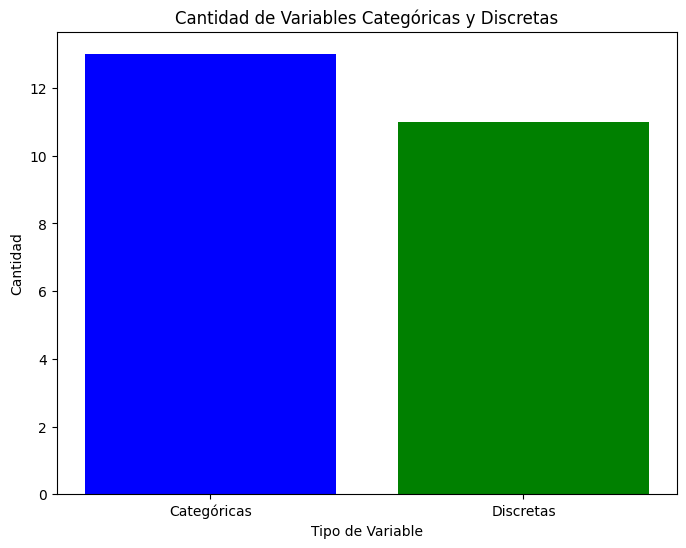

In [11]:
# 5.3 a) Grafica de barras variables categoricas y discretas

# Definir las etiquetas y alturas de las barras
etiquetas = ['Categóricas', 'Discretas']
alturas = [cantidad_categoricas, cantidad_discretas]

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
plt.bar(etiquetas, alturas, color=['blue', 'green'])

# Añadir título y etiquetas
plt.title('Cantidad de Variables Categóricas y Discretas')
plt.xlabel('Tipo de Variable')
plt.ylabel('Cantidad')

# Mostrar la gráfica
plt.show()

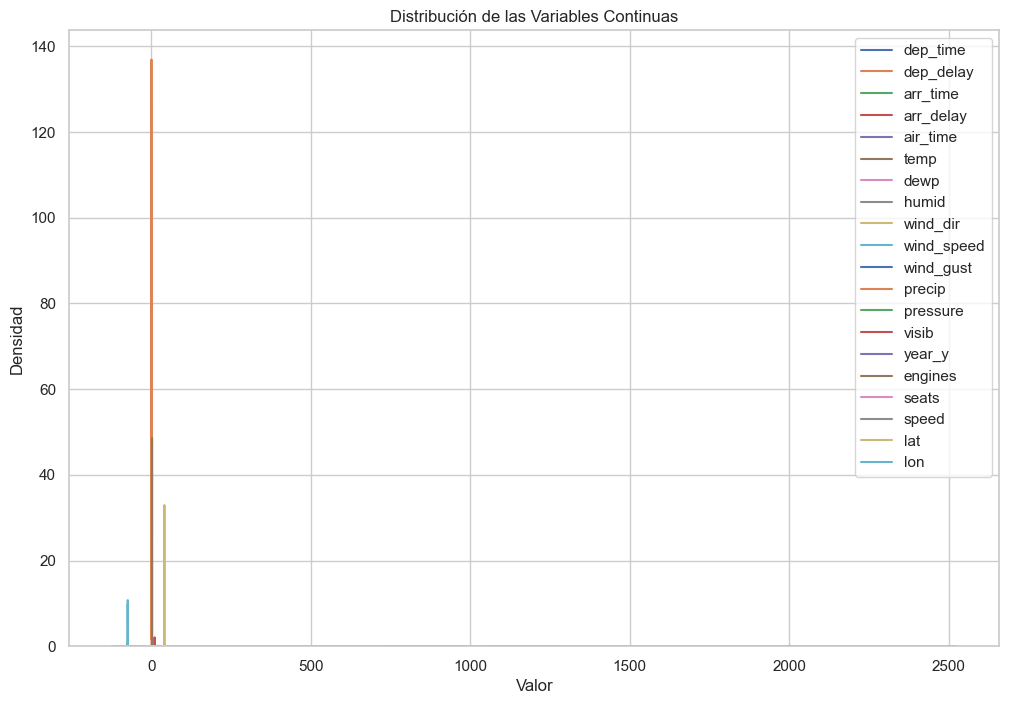

In [12]:
# 5.3 b) Grafica de densidad para variables continuas

# Seleccionar solo las variables continuas
variables_continuas = merged_df.select_dtypes(include=['float64'])

# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear una figura y ejes para la gráfica
plt.figure(figsize=(12, 8))

# Iterar sobre cada variable continua y trazar su densidad
for column in variables_continuas.columns:
    sns.kdeplot(data=merged_df[column], label=column)

# Añadir título y etiquetas
plt.title('Distribución de las Variables Continuas')
plt.xlabel('Valor')
plt.ylabel('Densidad')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

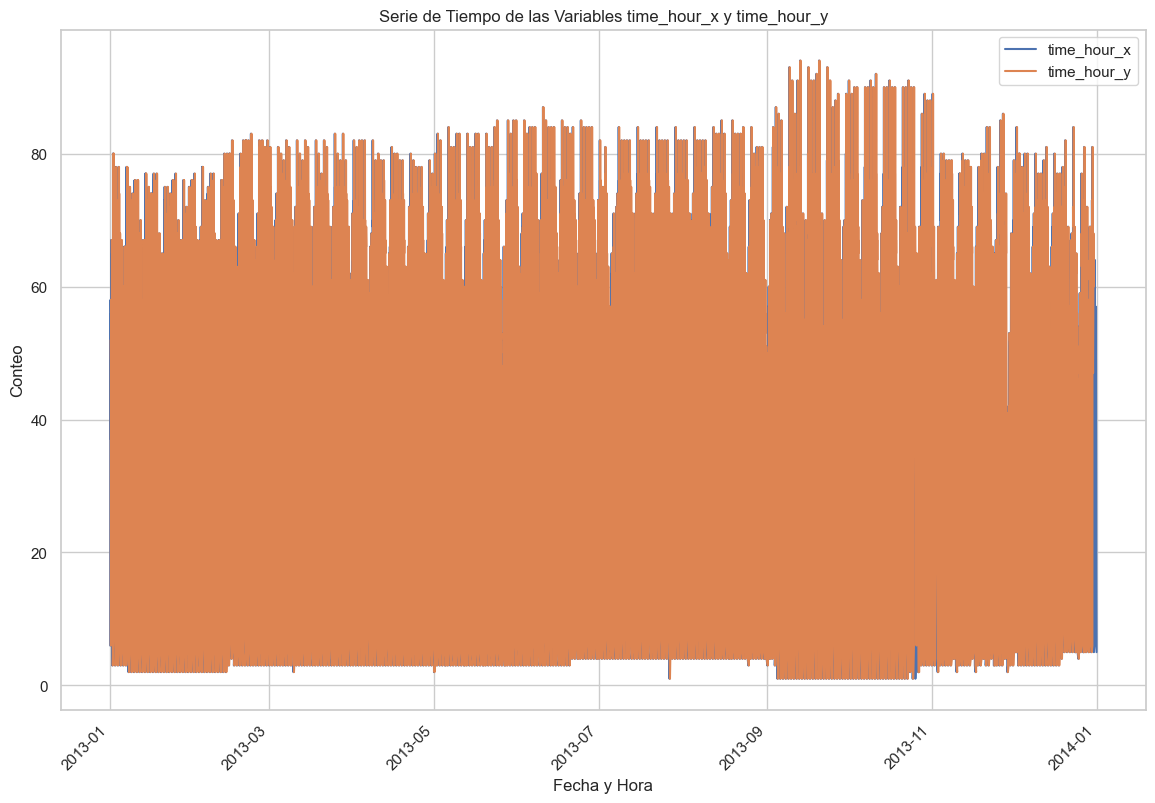

In [65]:
# 5.3 c) Grafica serie de tiempo para variables de fecha y hora

# Crear una figura y ejes para la gráfica de serie de tiempo
plt.figure(figsize=(14, 10))

# Trazar la serie de tiempo para time_hour_x
merged_df['time_hour_x'].value_counts().sort_index().plot(label='time_hour_x')

# Trazar la serie de tiempo para time_hour_y
merged_df['time_hour_y'].value_counts().sort_index().plot(label='time_hour_y')

# Añadir título y etiquetas
plt.title('Serie de Tiempo de las Variables time_hour_x y time_hour_y')
plt.xlabel('Fecha y Hora')
plt.ylabel('Conteo')

# Mostrar la leyenda
plt.legend()

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

### Preguntas planteadas 

In [35]:
# 1. ¿Cuales son los destinos de vuelo mas frecuentes?

# Contar las apariciones de cada destino de vuelo
destinos_frecuentes = flights_df['dest'].value_counts()

# Mostrar los destinos más frecuentes
print("Destinos de vuelo más frecuentes:")
print(destinos_frecuentes.head(3))

Destinos de vuelo más frecuentes:
dest
ORD    17283
ATL    17215
LAX    16174
Name: count, dtype: int64


In [36]:
# 2. ¿Que aerolinea tiene el mayor numero de vuelos?

# Contar el número de vuelos para cada aerolínea
numero_vuelos_por_aerolinea = flights_df['carrier'].value_counts()

# Encontrar la aerolínea con el mayor número de vuelos
aerolinea_mayor_numero_vuelos = numero_vuelos_por_aerolinea.idxmax()

# Mostrar la aerolínea con el mayor número de vuelos
print("La aerolínea con el mayor número de vuelos es:", aerolinea_mayor_numero_vuelos)


La aerolínea con el mayor número de vuelos es: UA


In [43]:
# 3. ¿Como afecta el clima a los retrasos de los vuelos? 

# Paso 1: Unir los DataFrames
flights_weather_df = pd.merge(flights_df, weather_df, on=['year', 'month', 'day', 'hour', 'origin'])

# Paso 2: Calcular la correlación
correlation_matrix = flights_weather_df[['dep_delay', 'arr_delay', 'temp', 'humid', 'wind_speed', 'precip']].corr()

# Mostrar la tabla de correlación
print("Tabla de correlación entre Variables Meteorológicas y Retrasos de Vuelo:")
print(correlation_matrix)

Tabla de correlación entre Variables Meteorológicas y Retrasos de Vuelo:
            dep_delay  arr_delay      temp     humid  wind_speed    precip
dep_delay    1.000000   0.914805  0.061491  0.117494    0.047424  0.090400
arr_delay    0.914805   1.000000  0.033026  0.141397    0.064069  0.111281
temp         0.061491   0.033026  1.000000  0.035520   -0.146848  0.010341
humid        0.117494   0.141397  0.035520  1.000000   -0.192249  0.236107
wind_speed   0.047424   0.064069 -0.146848 -0.192249    1.000000  0.037896
precip       0.090400   0.111281  0.010341  0.236107    0.037896  1.000000


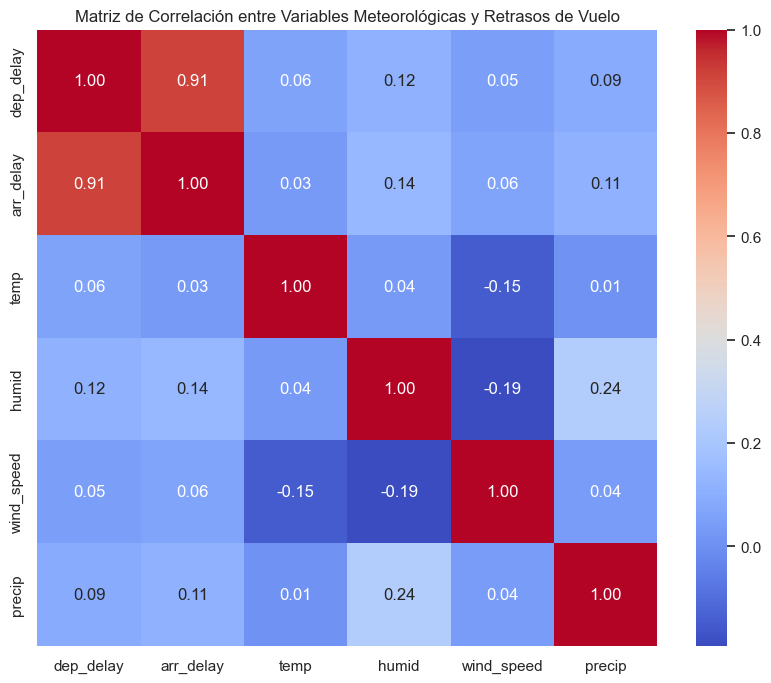

In [42]:
# Crear mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables Meteorológicas y Retrasos de Vuelo')
plt.show()

In [53]:
# 4. ¿Qué aeropuerto tiene la mayor diferencia entre el número de salidas y llegadas?

# Calcular el número de salidas por aeropuerto
salidas_por_aeropuerto = flights_df['origin'].value_counts()

# Calcular el número de llegadas por aeropuerto
llegadas_por_aeropuerto = flights_df['dest'].value_counts()

# Calcular la diferencia entre salidas y llegadas para cada aeropuerto
diferencia_salidas_llegadas = salidas_por_aeropuerto - llegadas_por_aeropuerto

# Encontrar el aeropuerto con la mayor diferencia
aeropuerto_max_diferencia = diferencia_salidas_llegadas.idxmax()

# Mostrar el aeropuerto con la mayor diferencia
print("El aeropuerto con la mayor diferencia entre el número de salidas y llegadas es:", aeropuerto_max_diferencia)

El aeropuerto con la mayor diferencia entre el número de salidas y llegadas es: LGA


In [45]:
# 5. ¿Que aeropuerto tiene el mayor numero de salidas y llegadas?

# Unir flights_df con airports_df para obtener información sobre los aeropuertos
flights_airports_df = pd.merge(flights_df, airports_df, left_on='origin', right_on='airport_code')

# Contar el número de salidas por aeropuerto
salidas_por_aeropuerto = flights_airports_df['name'].value_counts()

# Unir de nuevo flights_df con airports_df para obtener información sobre los aeropuertos de llegada
merged_data = pd.merge(flights_df, airports_df, left_on='dest', right_on='airport_code')

# Contar el número de llegadas por aeropuerto
llegadas_por_aeropuerto = merged_data['name'].value_counts()

# Encontrar el aeropuerto con el mayor número de salidas
aeropuerto_con_mas_salidas = salidas_por_aeropuerto.idxmax()

# Encontrar el aeropuerto con el mayor número de llegadas
aeropuerto_con_mas_llegadas = llegadas_por_aeropuerto.idxmax()

# Mostrar los resultados
print("El aeropuerto con el mayor número de salidas es:", aeropuerto_con_mas_salidas)
print("El aeropuerto con el mayor número de llegadas es:", aeropuerto_con_mas_llegadas)


El aeropuerto con el mayor número de salidas es: Newark Liberty Intl
El aeropuerto con el mayor número de llegadas es: Chicago Ohare Intl


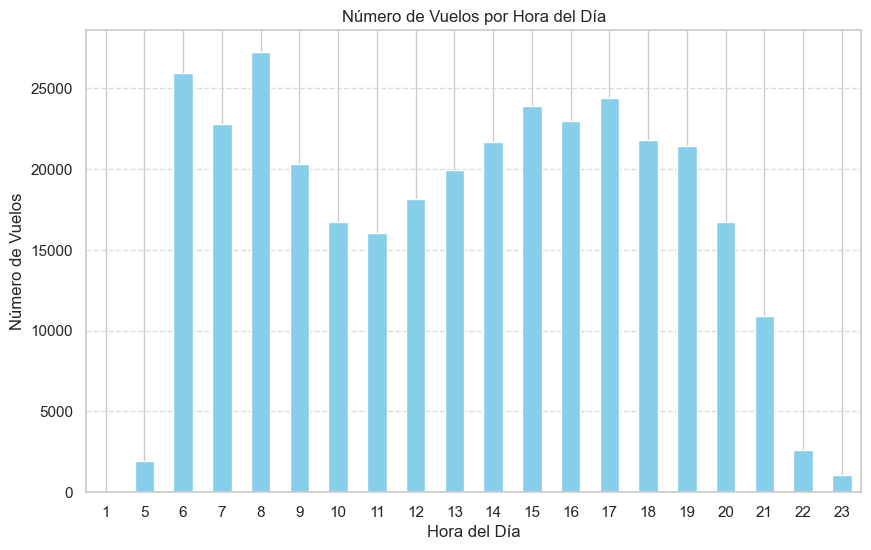

In [62]:
# 6. ¿Cómo varía el número de vuelos por hora del día?

# Agrupar los datos por hora del día
vuelos_por_hora = flights_df.groupby('hour').size()

# Crear un gráfico de barras para visualizar la distribución del número de vuelos por hora del día
plt.figure(figsize=(10, 6))
vuelos_por_hora.plot(kind='bar', color='skyblue')
plt.title('Número de Vuelos por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Vuelos')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

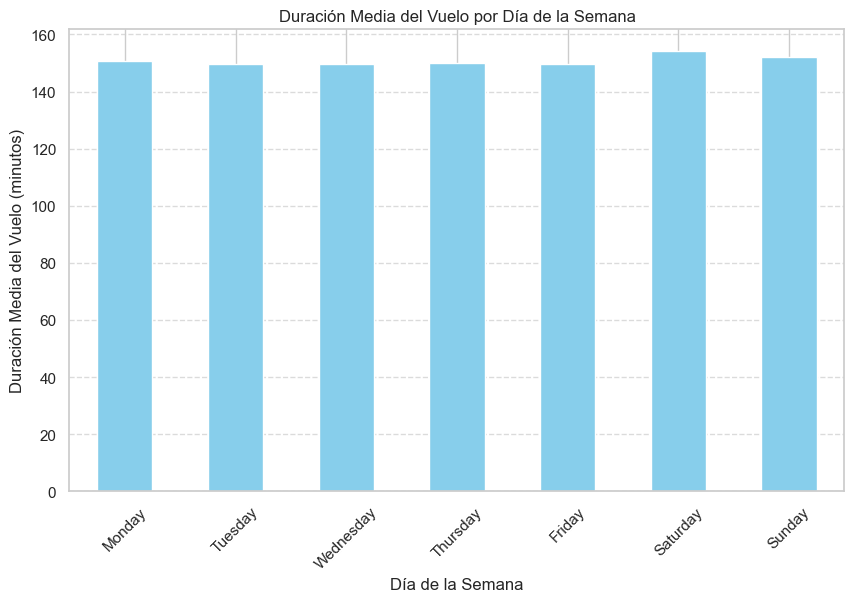

In [63]:
# 7. ¿Como varía la duracion media del vuelo durante diferentes dias de la semana?

# Convertir la columna 'time_hour' a tipo de datos de fecha y hora si no está en ese formato
flights_df['time_hour'] = pd.to_datetime(flights_df['time_hour'])

# Obtener el nombre del día de la semana
flights_df['day_of_week'] = flights_df['time_hour'].dt.day_name()

# Agrupar los datos por día de la semana y calcular la duración media del vuelo
duracion_media_por_dia = flights_df.groupby('day_of_week')['air_time'].mean()

# Ordenar los días de la semana en orden natural
dias_semana_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Crear un gráfico de barras para visualizar la variación de la duración media del vuelo por día de la semana
plt.figure(figsize=(10, 6))
duracion_media_por_dia.reindex(dias_semana_ordenados).plot(kind='bar', color='skyblue')
plt.title('Duración Media del Vuelo por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Duración Media del Vuelo (minutos)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [60]:
# 8. ¿Cual es el tiempo promedio de retraso por aerolinea?

# Calcular el tiempo promedio de retraso por aerolínea para salidas
promedio_retraso_salida = flights_df.groupby('carrier')['dep_delay'].mean()

# Calcular el tiempo promedio de retraso por aerolínea para llegadas
promedio_retraso_llegada = flights_df.groupby('carrier')['arr_delay'].mean()

# Combinar los dos resultados en un solo DataFrame
promedio_retraso_por_aerolinea = pd.DataFrame({
    'Tiempo Promedio de Retraso en Salida': promedio_retraso_salida,
    'Tiempo Promedio de Retraso en Llegada': promedio_retraso_llegada
})

# Mostrar el DataFrame con los resultados
display(promedio_retraso_por_aerolinea.head(5))

,Tiempo Promedio de Retraso en Salida,Tiempo Promedio de Retraso en Llegada
carrier,,
9E,16.725769,7.379669
AA,8.586016,0.364291
AS,5.804775,-9.930889
B6,13.022522,9.457973
DL,9.264505,1.644341


In [59]:
# 9. ¿Cuál es el tiempo promedio de retraso por tipo de aeronave?

# Calcular el tiempo promedio de retraso por tipo de aeronave para salidas
promedio_retraso_por_tipo_avion_salida = flights_df.groupby('tailnum')['dep_delay'].mean()

# Calcular el tiempo promedio de retraso por tipo de aeronave para llegadas
promedio_retraso_por_tipo_avion_llegada = flights_df.groupby('tailnum')['arr_delay'].mean()

# Combinar los dos resultados en un solo DataFrame
promedio_retraso_por_tipo_avion = pd.DataFrame({
    'Tiempo Promedio de Retraso en Salida por Tipo de Aeronave': promedio_retraso_por_tipo_avion_salida,
    'Tiempo Promedio de Retraso en Llegada por Tipo de Aeronave': promedio_retraso_por_tipo_avion_llegada
})

# Mostrar el DataFrame con los resultados
display(promedio_retraso_por_tipo_avion.head(5))

,Tiempo Promedio de Retraso en Salida por Tipo de Aeronave,Tiempo Promedio de Retraso en Llegada por Tipo de Aeronave
tailnum,,
D942DN,31.500000,31.500000
N0EGMQ,8.491525,9.982955
N10156,17.815068,12.717241
N102UW,8.000000,2.937500
N103US,-3.195652,-6.934783


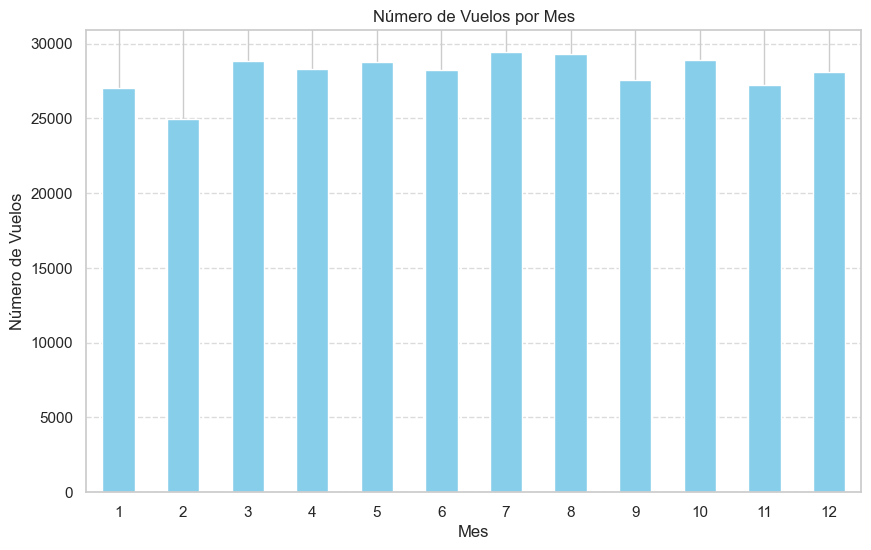

In [51]:
# 10. ¿En que epoca del ano hay un mayor numero de vuelos?

# Agrupar los datos por mes y contar el número de vuelos en cada mes
vuelos_por_mes = flights_df.groupby('month').size()

# Crear un gráfico de barras para visualizar la distribución de vuelos a lo largo de los meses
plt.figure(figsize=(10, 6))
vuelos_por_mes.plot(kind='bar', color='skyblue')
plt.title('Número de Vuelos por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Vuelos')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
